In [1]:
%matplotlib inline
import epi_prediction
import numpy as np

##Load Mask

In [2]:
white_matter = epi_prediction.SimpleMasker('masks/white.nii', .2)

##Import Data

In [3]:
src_dir = '/home/nick/Desktop/dki_stuff/modalities'

control_filter = lambda file_name: 'CON' in file_name
patient_filter = lambda file_name: 'PAT' in file_name

In [4]:
epi_paths = epi_prediction.get_epi_paths(src_dir, patient_filter, control_filter)

NameError: name 'epi_prediction' is not defined

In [5]:
pats_than_cons = lambda mod: epi_paths[mod]['pats'] + epi_paths[mod]['cons']

In [6]:
mat = epi_prediction.hstack(white_matter, 
                            True, 
                            pats_than_cons('dmean'), 
                            pats_than_cons('fa'), 
                            pats_than_cons('kmean'))

--------------------------------------------------------------------
####################################################################--------------------------------------------------------------------
####################################################################--------------------------------------------------------------------
####################################################################

In [7]:
mat.shape


(68, 402789)

In [8]:
labels = len(epi_paths['dmean']['pats']) * [1] + len(epi_paths['dmean']['cons']) * [0]

In [9]:
len(labels)

68

##Create Feature Selection That Combines Modalities

In [10]:
from __future__ import division

dist = (int)(mat.shape[1]/3)

index_map = {"dmean": (0, dist),
             "fa":  (dist, 2 * dist),
             "kmean": (2*dist, 3*dist)}

index_map

{'dmean': (0, 134263), 'fa': (134263, 268526), 'kmean': (268526, 402789)}

In [11]:
from nilearn.input_data import NiftiMasker
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [12]:
def new_anova(mod, k=500): 
    return Pipeline([
        ('columns', epi_prediction.ColumnSelector(index_map[mod])),
        ('anova', SelectKBest(k=k))
    ])


# does this use the classified information ? 

In [13]:
from sklearn.pipeline import FeatureUnion

anovas = FeatureUnion([ (m, new_anova(m)) for m in index_map])

In [14]:
anovas

FeatureUnion(n_jobs=1,
       transformer_list=[('fa', Pipeline(steps=[('columns', ColumnSelector(col_indexes=(134263, 268526))), ('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7ff692727230>))])), ('dmean', Pipeline(steps=[('columns', ColumnSelector(col_indexes=(0, 134263))), ('anova', SelectKBest(k=500, score_...526, 402789))), ('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7ff692727230>))]))],
       transformer_weights=None)

##Initialize SVC

In [15]:
feature_selection_svc = Pipeline([('feature_selection', anovas), ('svc', SVC())])
feature_selection_svc

Pipeline(steps=[('feature_selection', FeatureUnion(n_jobs=1,
       transformer_list=[('fa', Pipeline(steps=[('columns', ColumnSelector(col_indexes=(134263, 268526))), ('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7ff692727230>))])), ('dmean', Pipeline(steps=[('columns', ColumnSelector(col...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

##Grid Search for Best Parameters of Gamma and C

In [16]:
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(svc__gamma=gamma_range, svc__C=C_range)
n_folds = np.floor_divide(32, 5)

cv = StratifiedKFold(labels, n_folds=n_folds)

In [17]:
total_runs = len(C_range) * len(gamma_range) * n_folds

scorer = epi_prediction.verbose_scorer(total_runs)
grid = GridSearchCV(feature_selection_svc, param_grid=param_grid, cv=cv, scoring = scorer)

grid.fit(mat, labels)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/usr/local/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('feature_selection', FeatureUnion(n_jobs=1,
       transformer_list=[('fa', Pipeline(steps=[('columns', ColumnSelector(col_indexes=(134263, 268526))), ('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7ff692727230>))])), ('dmean', Pipeline(steps=[('columns', ColumnSelector(col...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'svc__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,

In [18]:
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
scores

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.41981793,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.68464052,  0.71289593,  0.59601918,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.68464052,  0.73479135,  0.71895425,  0.57429972,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.68464052,
         0.73479135,  0.71895425,  0.71895425,  0.57429972,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

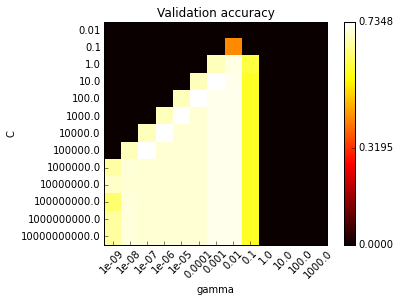

In [19]:
import matplotlib.pyplot as plt

cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.hot)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.xlabel('gamma')
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel('C')
plt.title('Validation accuracy')

cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])

plt.show()

In [20]:
scores.shape

(13, 13)

In [21]:
np.max(scores)

0.73479135243841132

In [22]:
C = C_range[2]
gamma = gamma_range[7]
scores[2][7]

0.71289592760181009

##Try Lower Dimensionality

In [23]:
anovas_450 = FeatureUnion([ (m, new_anova(m, k=150)) for m in index_map])
feature_selection_svc_450 = Pipeline([('feature_selection', anovas_450), ('svc', SVC())])
grid_450 = GridSearchCV(feature_selection_svc_450, param_grid=param_grid, cv=cv, scoring = scorer)

In [24]:
from sklearn.grid_search import RandomizedSearchCV
random_450 = RandomizedSearchCV(feature_selection_svc_450, param_distributions=param_grid, cv=cv, scoring = scorer)

In [25]:
random_450.fit(mat, labels)

############################################################

RandomizedSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
          error_score='raise',
          estimator=Pipeline(steps=[('feature_selection', FeatureUnion(n_jobs=1,
       transformer_list=[('fa', Pipeline(steps=[('columns', ColumnSelector(col_indexes=(134263, 268526))), ('anova', SelectKBest(k=150, score_func=<function f_classif at 0x7ff692727230>))])), ('dmean', Pipeline(steps=[('columns', ColumnSelector(col...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'svc__gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'svc__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,

In [26]:
random_450.grid_scores_

[mean: 0.00000, std: 0.00000, params: {'svc__gamma': 10.0, 'svc__C': 10000000000.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 1.0000000000000001e-05, 'svc__C': 10.0},
 mean: 0.43336, std: 0.21426, params: {'svc__gamma': 0.001, 'svc__C': 1.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 1.0, 'svc__C': 10000000.0},
 mean: 0.69697, std: 0.14559, params: {'svc__gamma': 1.0000000000000001e-05, 'svc__C': 1000000.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 100.0, 'svc__C': 100000000.0},
 mean: 0.74412, std: 0.14642, params: {'svc__gamma': 1e-08, 'svc__C': 10000000000.0},
 mean: 0.69621, std: 0.18814, params: {'svc__gamma': 1.0000000000000001e-09, 'svc__C': 10000000.0},
 mean: 0.43336, std: 0.21426, params: {'svc__gamma': 0.0001, 'svc__C': 10.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 1e-08, 'svc__C': 1000.0}]

##Explore if PCA can Better Select Features

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=20)
pca.fit(mat, labels)

PCA(copy=True, n_components=20, whiten=False)

In [29]:
pca.explained_variance_ratio_

array([ 0.21797068,  0.08451933,  0.04719787,  0.03515985,  0.03011981,
        0.0236962 ,  0.02220851,  0.02181247,  0.01787787,  0.01699752,
        0.01645817,  0.01575456,  0.01452591,  0.01401594,  0.0135983 ,
        0.01271394,  0.01239047,  0.01220256,  0.01198456,  0.01153273], dtype=float32)

In [30]:
np.sum(pca.explained_variance_ratio_)

0.65273732

__Each new dimension still capturing variance, increase a little more__

In [31]:
pca = PCA(n_components=100)
pca.fit(mat, labels)

/usr/local/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


PCA(copy=True, n_components=100, whiten=False)

In [32]:
pca.explained_variance_ratio_

array([  2.17970684e-01,   8.45193341e-02,   4.71978672e-02,
         3.51598524e-02,   3.01198121e-02,   2.36961972e-02,
         2.22085081e-02,   2.18124725e-02,   1.78778730e-02,
         1.69975199e-02,   1.64581705e-02,   1.57545581e-02,
         1.45259099e-02,   1.40159409e-02,   1.35983005e-02,
         1.27139352e-02,   1.23904739e-02,   1.22025600e-02,
         1.19845578e-02,   1.15327295e-02,   1.12301540e-02,
         1.11266794e-02,   1.07760346e-02,   1.05246492e-02,
         1.03212334e-02,   1.00578163e-02,   9.74796712e-03,
         9.49515309e-03,   9.31263342e-03,   9.19554941e-03,
         8.91812705e-03,   8.86134245e-03,   8.52060784e-03,
         8.32910370e-03,   8.20756424e-03,   8.15869682e-03,
         7.93681946e-03,   7.91312288e-03,   7.77330203e-03,
         7.58283306e-03,   7.53953774e-03,   7.50652794e-03,
         7.35501293e-03,   7.31272809e-03,   7.06428988e-03,
         6.98405784e-03,   6.87036617e-03,   6.69304002e-03,
         6.63704192e-03,

In [33]:
np.sum(pca.explained_variance_ratio_)

0.99999988

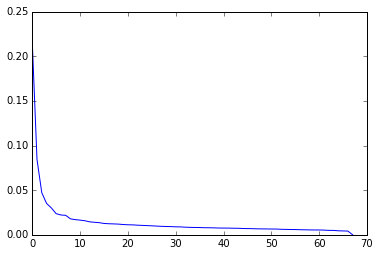

In [34]:
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [35]:
np.sum(pca.explained_variance_ratio_[:65])

0.99149513

_We Are Able to Capture Almost all variance with 65 dimensions, we may use this later._

##Calculate Confusion Matrix

In [36]:
labels_arr = np.array(labels)

feature_selection_svc.set_params(svc__C=C, svc__gamma=gamma)

cv_info, cv_info_train = epi_prediction.verbose_cv(mat, 
                                                   labels_arr, 
                                                   feature_selection_svc,
                                                   n_folds=n_folds,
                                                   verbose=False)

####
####
####
####
####
####


In [37]:
cv_info.avg_f1_score()

0.71293706293706294

In [38]:
cv_info.confusion_matrix()

array([[28,  8],
       [ 9, 23]])

In [39]:
cv_info.normalized_confusion_matrix()

array([[ 0.77777778,  0.22222222],
       [ 0.28125   ,  0.71875   ]])

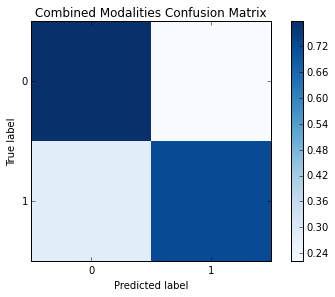

In [40]:
epi_prediction.plot_confusion_matrix(cv_info.normalized_confusion_matrix(), 
                      title="Combined Modalities Confusion Matrix")

##Try Just Best 500 instead of 1500

In [41]:
k = 500
feature_selection = SelectKBest(f_classif, k=k)
svc = SVC()
anova_500_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [42]:
scorer = epi_prediction.verbose_scorer(total_runs)
grid_wmatter_500 = GridSearchCV(anova_500_svc, 
                            param_grid=param_grid, 
                            cv=cv, scoring = scorer)

grid_wmatter_500.fit(mat, labels)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7ff692727230>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'svc__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
   

In [43]:
scores = [x[1] for x in grid_wmatter_500.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
scores

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.67491087,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.67491087,  0.69353832,  0.70309821,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.67491087,  0.70637255,  0.68888146,  0.70309821,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.67491087,  0.69166667,  0.67818627,  0.68888146,  0.70309821,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

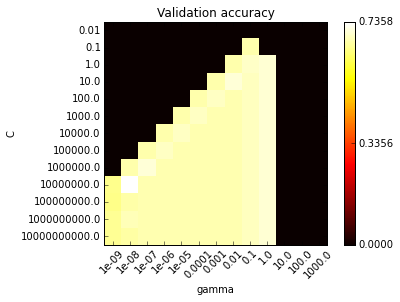

In [44]:
cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.hot)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.xlabel('gamma')
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel('C')
plt.title('Validation accuracy')

cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])

plt.show()

In [45]:
C = C_range[8]
gamma = gamma_range[1]
scores[8][1]

0.67491087344028511

In [46]:
reload(epi_prediction)

<module 'epi_prediction' from 'epi_prediction.pyc'>

In [47]:
white_matter = epi_prediction.SimpleMasker('masks/white.nii', .2)

##Unsatisfactory Results, need new way to combine

__Will Try Combining Probalities from the SVM Outputs__

_Know the Best Params for Each SVM from other experiments_

In [48]:
svc_params_map = dict(dmean=dict(C=.01),
                      kmean=dict(C=1),
                      fa=dict(C=.1))

In [49]:
def new_anova_and_svc(mod, k=500): 
    svc = SVC()
    svc.kernel='linear'
    svc.C = svc_params_map[mod]['C']
    svc.probability=True
    return Pipeline([
        ('columns', epi_prediction.ColumnSelector(index_map[mod])),
        ('anova', SelectKBest(k=k)),
        ('svc', svc)
    ])
    
svcs = [new_anova_and_svc(m) for m in index_map]

In [50]:
combined_alg = epi_prediction.ProbableBinaryEnsembleAlg(svcs)

In [51]:
cv_combos, cv_combos_train = epi_prediction.verbose_cv(mat, labels_arr, combined_alg, n_folds=6, verbose=False)

####
####
####
####
####
####


In [52]:
reload(epi_prediction)

<module 'epi_prediction' from 'epi_prediction.pyc'>

In [53]:
cv_combos.avg_f1_score()

0.74020979020979016

In [54]:
cv_combos.normalized_confusion_matrix()

array([[ 0.80555556,  0.19444444],
       [ 0.25      ,  0.75      ]])

In [55]:
cv_combos.f1_scores()

[0.92307692307692302,
 0.59999999999999998,
 0.90909090909090906,
 0.59999999999999998,
 0.5,
 0.90909090909090906]

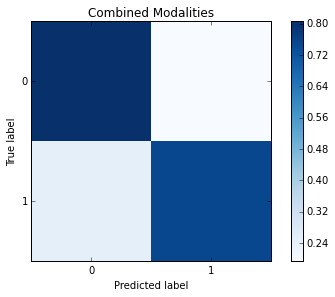

In [56]:
epi_prediction.plot_confusion_matrix(cv_combos.normalized_confusion_matrix(), "Combined Modalities")

##Good Results, Lets Compare With Removing Modalities

In [57]:
[m for m in index_map]

['fa', 'dmean', 'kmean']

In [58]:
svcs_no_kmean = [new_anova_and_svc(m) for m in ['fa', 'dmean']]

In [59]:
combined_alg_no_kmean = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_kmean)
cv_combos_no_kmean, cv_combos_train_no_kmean = epi_prediction.verbose_cv(mat, 
                                                                         labels_arr, 
                                                                         combined_alg_no_kmean,
                                                                         n_folds=6, 
                                                                         verbose=False)

####
####
####
####
####
####


In [60]:
cv_combos_no_kmean.avg_f1_score()

0.67520257520257509

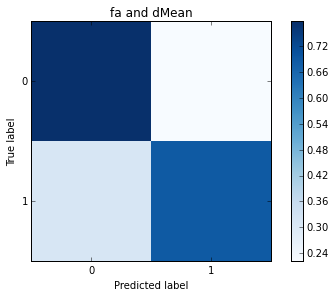

In [61]:
epi_prediction.plot_confusion_matrix(cv_combos_no_kmean.normalized_confusion_matrix(), "fa and dMean")

In [62]:
cv_combos_no_kmean.normalized_confusion_matrix()

array([[ 0.77777778,  0.22222222],
       [ 0.3125    ,  0.6875    ]])

_kMean is a major contributor, next examine contribution from other 2_

In [63]:
svcs_no_fa = [new_anova_and_svc(m) for m in ['kmean', 'dmean']]
combined_alg_no_fa = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_fa)
cv_combos_no_fa, cv_combos_train_no_fa = epi_prediction.verbose_cv(mat, 
                                                                   labels_arr, 
                                                                   combined_alg_no_fa,
                                                                   n_folds=6, 
                                                                   verbose=False)

####
####
####
####
####
####


In [64]:
cv_combos_no_fa.avg_f1_score()

0.70449550449550447

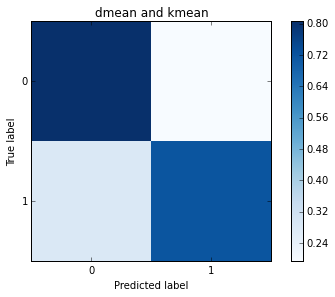

In [65]:
epi_prediction.plot_confusion_matrix(cv_combos_no_fa.normalized_confusion_matrix(), "dmean and kmean")

In [66]:
cv_combos_no_fa.normalized_confusion_matrix()

array([[ 0.80555556,  0.19444444],
       [ 0.28125   ,  0.71875   ]])

_let's try one more time with no dmean_

In [67]:
svcs_no_dmean = [new_anova_and_svc(m) for m in ['kmean', 'fa']]
combined_alg_no_dmean = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_dmean)
cv_combos_no_dmean, cv_combos_train_no_dmean = epi_prediction.verbose_cv(mat, 
                                                                         labels_arr, 
                                                                         combined_alg_no_dmean,
                                                                         n_folds=6, 
                                                                         verbose=False)

####
####
####
####
####
####


In [68]:
cv_combos_no_dmean.avg_f1_score()

0.70479797979797976

In [69]:
cv_combos_no_dmean.normalized_confusion_matrix()

array([[ 0.77777778,  0.22222222],
       [ 0.28125   ,  0.71875   ]])

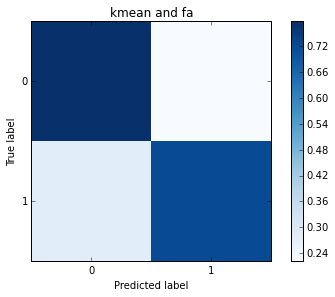

In [70]:
epi_prediction.plot_confusion_matrix(cv_combos_no_dmean.normalized_confusion_matrix(), "kmean and fa")